# Ice Sheet Model

- Chiemi Tagami (CC'24)

## Overview:

This Jupyter Notebook analyzes the data from Antarctic Ice Sheet simulation model. The codes are adapted from 

https://github.com/ldeo-glaciology/pangeo-glaciology-examples/blob/master/04_paleo_PISM.ipynb

and the dataset is obtained from

Albrecht, Torsten (2019): PISM parameter ensemble analysis of Antarctic Ice Sheet glacial cycle simulations. PANGAEA, https://doi.pangaea.de/10.1594/PANGAEA.909728

### Definition of the ensemble parameters:
- par_esia: shallow-ice approximation (SIA) enhancement factor
- par_ppq: exponent "q" used in pseudo-plastic sliding law
- par_prec: precipitation scaling factor according to temperature forcing
- par_visc: mantle visocsity

In [3]:
# load a package called intake, which is used to load the data. 
import intake

In [4]:
# load the intake catalog
cat = intake.open_catalog('https://raw.githubusercontent.com/ldeo-glaciology/pangeo-pismpaleo/main/paleopism.yaml')

# load each of the zarr diretories contained in the intake catalog
present  = cat["present"].to_dask()
mask_score_time_series  = cat["mask_score_time_series"].to_dask()

## Surface elevation plot

### 1. Mean

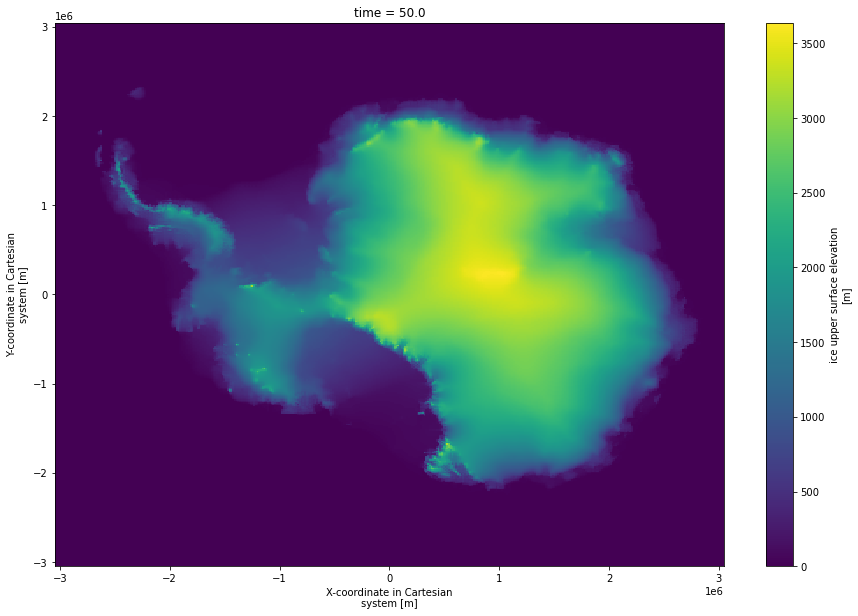

In [5]:
# At first, I plotted the mean upper surface elevation of the Antarctic Ice Sheet.
mean_usurf = present.usurf.mean({'par_esia','par_visc','par_ppq','par_prec'},keep_attrs=True)
mean_usurf.plot(size = 10)

This plot shows that the Antarctic Ice Sheet is the thickest at the center and thinnest at the periphery.

### 2. Standard Deviation

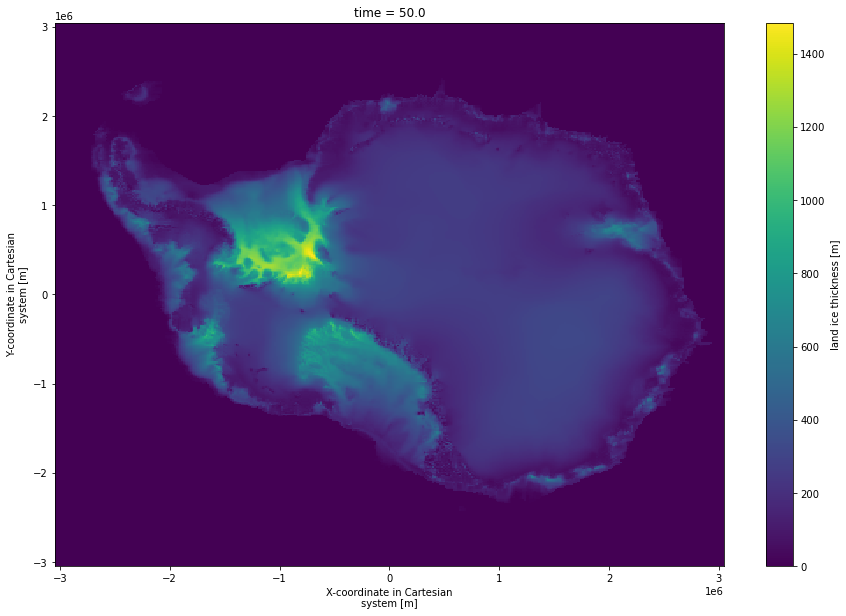

In [6]:
# Next, I plotted the standard deviation of the land ice thickness.
mean_std = present.thk.std({'par_esia','par_visc','par_ppq','par_prec'},keep_attrs=True)
mean_std.plot(size = 10)

This plot shows that the largest ice thickness variation appears at the Ronne Ice Shelf and Ross Ice Shelf.

## Anomaly Computation

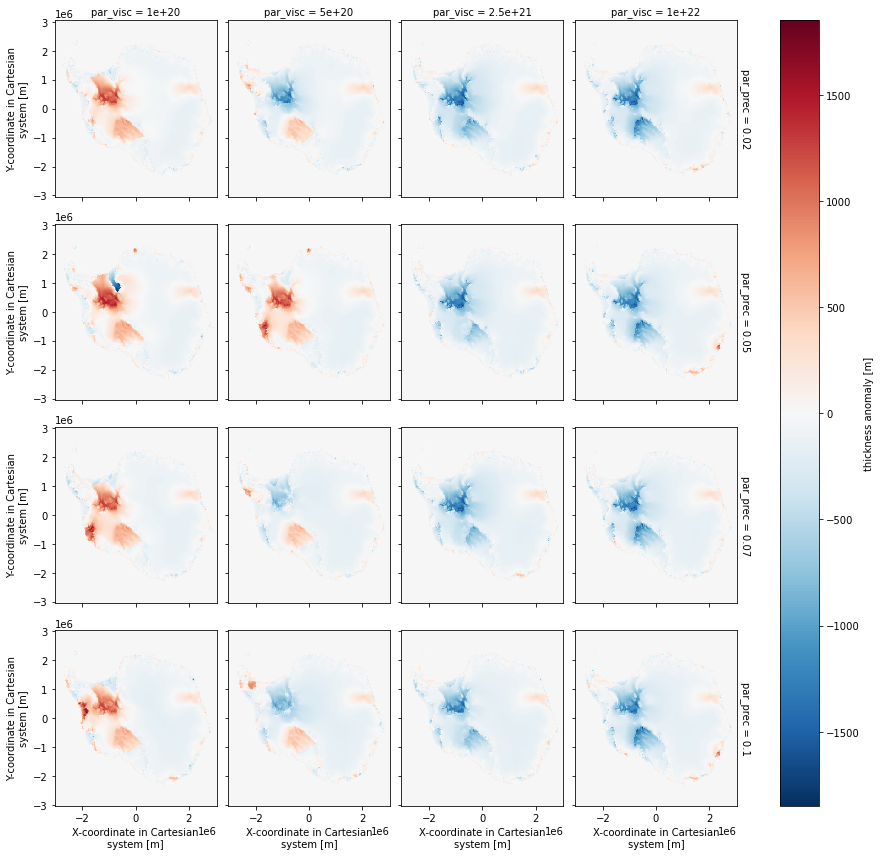

In [7]:
# After reading the methods section of the research paper, I thought that precipitation and viscosity 
# were the two most influencial parameters.
# I fixed the values of par_esia and par_ppq to be 2, as I wanted then to be the center value in the simulation model.
# The difference between the ice thickness and the ensemble-wide mean are shown below as an array of plots
mean_thk = present.thk.mean({'par_esia','par_visc','par_ppq','par_prec'},keep_attrs=True)
thickness_anomaly = (present.thk.isel(par_esia=2,par_ppq=2)-mean_thk)
thickness_anomaly.attrs['long_name'] = 'thickness anomaly'
thickness_anomaly.attrs['units'] = 'm'
thickness_anomaly.plot(x='x',y='y',col='par_visc',row='par_prec');

From observing these plots, I thought that the combination (par_esia= 4.0,par_ppq = 0.75, par_prec= 0.05,par_visc = 1e+20) was the most interesting because the ice thickness in the Ronne Ice Shelf is considerably larger compared to the overall mean, but there is also a large negative anomaly at the right side of the ice shelf. To get a further understanding of the characteristics of the Antarctic ice under this combination, I will proceed the following analysis by using this parameter combination:

1. Land ice thickness plot
2. Ice type plot for different time periods
3. Time series plot of the total ice sheet area


## 1. Land ice thickness plot

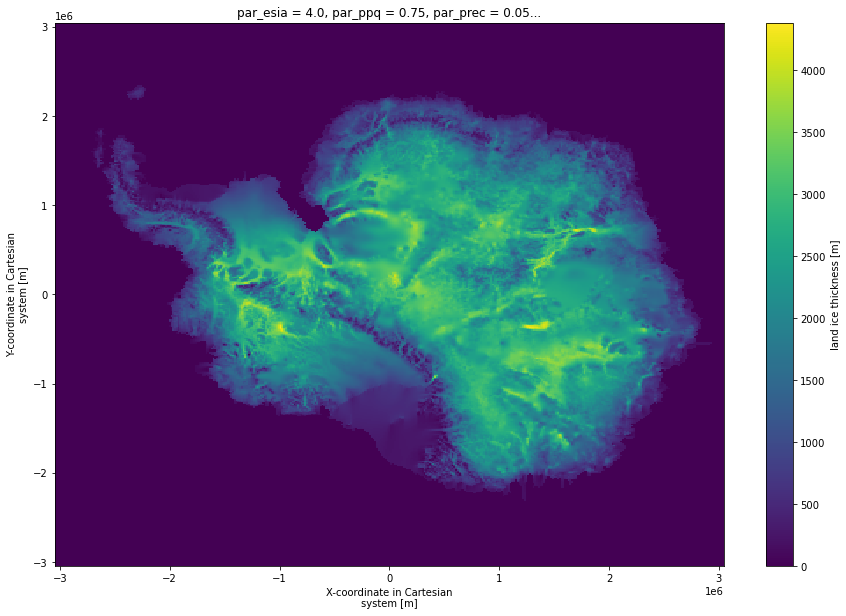

In [8]:
# Land ice thickness plotted for the comnbination (par_esia= 4.0,par_ppq = 0.75, par_prec= 0.05,par_visc = 1e+20)
present.thk.isel(par_esia=2,par_ppq = 2, par_prec= 1,par_visc = 0).plot(size = 10)

## 2. Ice type plot

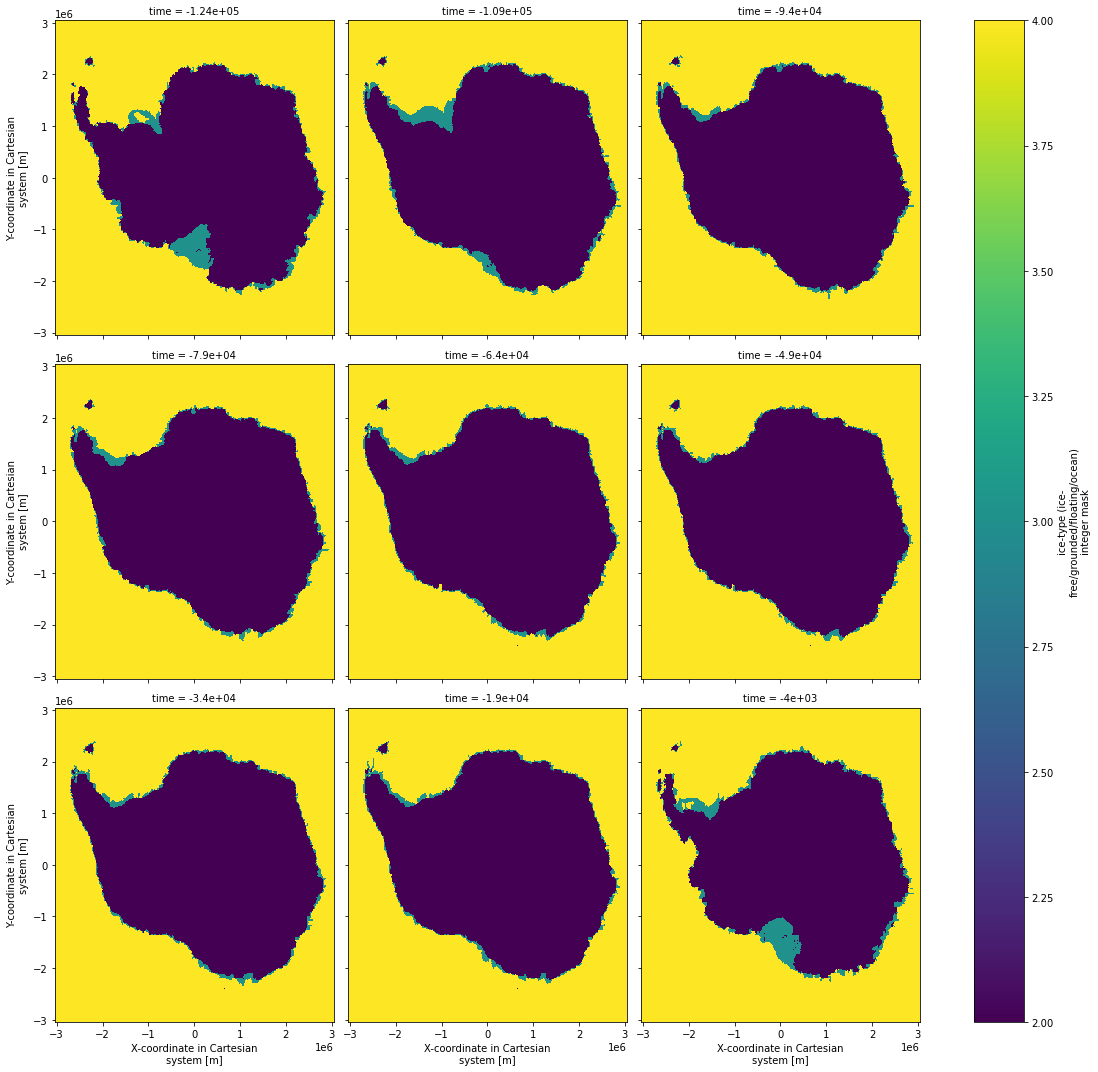

In [9]:
# Next, I plotted the ice type for 15 different time points by using the same parameters as before:
# (par_esia= 4.0,par_ppq = 0.75, par_prec= 0.05,par_visc = 1e+20).
mask_score_time_series.mask.isel(par_esia=2, par_ppq=2, par_prec=1, par_visc=0,
                       time=slice(0,124,15)).plot(x='x',y='y',col='time',col_wrap=3,size = 5)

The plots show that for the combination (par_esia= 4.0,par_ppq = 0.75, par_prec= 0.05,par_visc = 1e+20), the area of grounded ice increases rapidly until around 94,000 years ago, and it remains stable until around 19,000 years ago. However, a transformation is observed from grounded type to floating ice type afterwards. This suggests that a rapid deglaciation occurred in this time period for this parameter combination.

## 3. Time series plot of the total ice sheet area

In [10]:
# Finally, I plotted a time series of the total ice shelf area for the selected parameter combination.
cellArea = mask_score_time_series.x.attrs['spacing_meters'] * mask_score_time_series.y.attrs['spacing_meters']

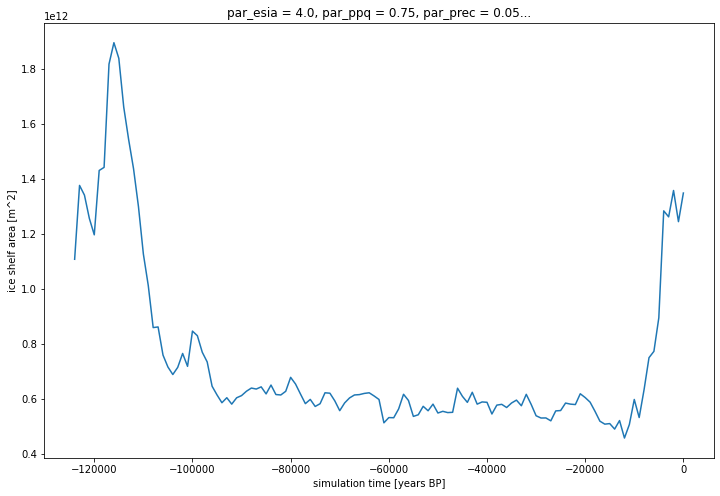

In [11]:
import xarray as xr
ice_shelf_area = (xr.where(mask_score_time_series.mask.isel(par_esia=2, par_ppq=2, par_prec=1, par_visc=0) == 3 ,1 ,0 ).sum(['x','y'])*cellArea)
ice_shelf_area.attrs['units'] = 'm^2'
ice_shelf_area.attrs['long_name'] = 'ice shelf area'
ice_shelf_area.time.attrs['long_name'] = 'simulation time'
ice_shelf_area.time.attrs['units'] = 'years BP'
p = ice_shelf_area.plot(size=8)

This plot shows that the ice shelf area for the combination (par_esia= 4.0,par_ppq = 0.75, par_prec= 0.05,par_visc = 1e+20) experiences a steep drop beginning from around 115,000 years ago. Ice shelf area remains roughly stable until around 10,000 years ago, and there is a dramatic increase afterwards. However, the ice shelf area does not does not recover to the peak value saw in 115,000 years ago. This plot implies that for the selected combination of parameters, the ice responds rapidly for both advance and retreat.